In [24]:
import sys

sys.path.append('../')

In [30]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tradercompany
from tradercompany.activation_funcs import identity, ReLU, sign, tanh
from tradercompany.binary_operators import add, diff, get_x, get_y, multiple, x_is_greater_than_y
from tradercompany.trader import Trader
from tradercompany.company import Company

%matplotlib inline


SEED = 2021
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_all_seeds(SEED)

In [45]:
sigma = 0.1
T_total = 1000

def create_dataset(T, sigma_t):
    def dynamics(y_t, sigma):
        y_next = np.zeros(2)
        y_next[0] = 1.0*tanh(y_t[0]) + 0.8*y_t[0]*y_t[1] + 1.0*y_t[1] - 1.0*ReLU(min(y_t[0], y_t[1])) + sigma*np.random.randn()
        y_next[1] = +0.6*sign(y_t[1]) + 0.5*y_t[0]*y_t[1] - 1.0*max(y_t[0], y_t[1]) + sigma*np.random.randn()
        return y_next
    
    y = np.zeros((2, T))
    y_without_noise = np.zeros((2, T))
    y[:,0] = np.array([0.5, 0.5])
    y_without_noise[:,0] = np.array([0.5, 0.5])
    
    for t in range(1, T):
        y[:,t] = dynamics(y[:,t-1], sigma_t)
        y_without_noise[:,t] = dynamics(y[:,t-1], 0.0)
    
    plt.xlim([T-100, T])
    plt.plot(y[0], color = "#cc0000", label = "stock0")
    plt.plot(y[1], color = "#083090", label = "stock1")
    plt.plot(y_without_noise[0], color = "#cc0000", linestyle = "--", label = "stock0" + "(w/o noise)")
    plt.plot(y_without_noise[1], color = "#083090", linestyle = "--", label = "stock1" + "(w/o noise)")
    plt.xlabel("time", fontsize = 18)
    plt.ylabel("y", fontsize = 18)
    plt.legend()
    plt.show()
    plt.close()
    
    return y, y_without_noise

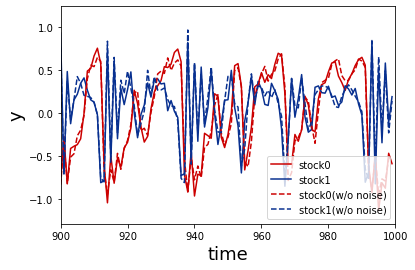

In [29]:
y, y_without_noise = create_dataset(T_total, sigma)

# Trader-Company method

In [4]:
activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [max, min, add, diff, multiple, get_x, get_y, x_is_greater_than_y]

In [33]:
time_window = 100
delay_time_max = 2
num_stock = len(y)
num_factors_max = 4

model = Company(y, num_stock, num_factors_max, delay_time_max, activation_funcs, binary_operators, num_traders=20, Q=0.2, time_window=time_window)
errors_test = []

num_test_data = 200 # test dataのサイズ
T = T_total - num_test_data # train dataのサイズ

for t in tqdm(range(delay_time_max+1, len(y[0]))):
    data_to_stack = y[:,t-delay_time_max-1:t] # t-1までのデータであることに注意
    model.observe(data_to_stack) # train, testいずれの場合でもstackしなければならない

    # train or test
    if delay_time_max + 1 + time_window < t <= T_train: # train
        model.educate(t)
        model.fire_and_recruit(t, y)
    elif T_train < t: # test
        prediction_test = model.aggregate()
        errors_test.append(np.abs(y[:,t] - prediction_test))

100%|██████████| 997/997 [02:54<00:00,  5.73it/s] 


# 比較

In [47]:
name_stock = ["stock0", "stock1"]

In [48]:
# smoothing
errors_test = np.array(errors_test)
errors_test = errors_test.T
days_to_smooth = 5
errors_smoothed = np.zeros((len(errors_test), len(errors_test[0])+days_to_smooth-1))
ones_to_smooth = np.ones(days_to_smooth) / days_to_smooth
for idx in range(len(name_stock)):
    errors_smoothed[idx] = np.convolve(errors_test[idx], ones_to_smooth)
print(errors_smoothed.shape)
# base line method
errors_baseline = np.abs(y[:,T+1:] - y[:,T:-1])
errors_baseline_smoothed = np.zeros((len(errors_baseline), len(errors_baseline[0])+days_to_smooth-1))
for idx in range(len(name_stock)):
    errors_baseline_smoothed[idx] = np.convolve(errors_baseline[idx], ones_to_smooth)

(2, 203)


In [49]:
p = 1
y_train = y[:,0:T]
y_test = y[:,T:]
# train
Y = y_train[:,p:T]
Z = np.ones((len(y_train)*p+1, T-p))
for t in range(p):
    Z[1+t*len(y_train):1+t*len(y_train)+len(y_train):,:] = y[:,p-1-t:T-1-t]
B = Y.dot(Z.T).dot(np.linalg.inv(Z.dot(Z.T)))

# predict
Z = np.ones((len(y_test)*p+1, len(y_test[0])-p))
for t in range(p):
    Z[1+t*len(y_test):1+t*len(y_test)+len(y_test):,:] = y_test[:,p-1-t:len(y_test[0])-1-t]
y_VAR = B.dot(Z)

# errors
errors_VAR = np.abs(y[:,T+p:] - y_VAR)
errors_VAR_smoothed = np.zeros((len(errors_VAR), len(errors_VAR[0])+days_to_smooth-1))
for idx in range(len(name_stock)):
    errors_VAR_smoothed[idx] = np.convolve(errors_VAR[idx], ones_to_smooth)


(2, 208)


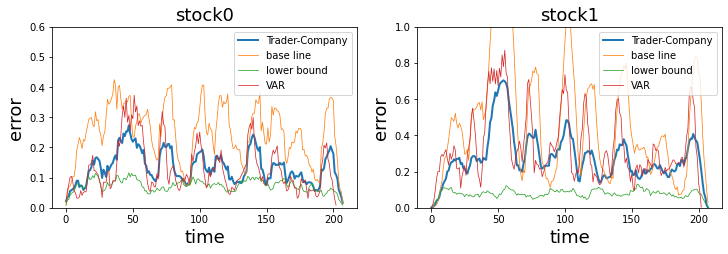

In [54]:
# smoothing
days_to_smooth = 10
errors_smoothed = np.zeros((len(errors_test), len(errors_test[0])+days_to_smooth-1))
ones_to_smooth = np.ones(days_to_smooth) / days_to_smooth
for idx in range(len(name_stock)):
    errors_smoothed[idx] = np.convolve(errors_test[idx], ones_to_smooth)
print(errors_smoothed.shape)
# base line method
errors_baseline = np.abs(y[:,T+1:] - y[:,T:-1])
errors_baseline_smoothed = np.zeros((len(errors_baseline), len(errors_baseline[0])+days_to_smooth-1))
for idx in range(len(name_stock)):
    errors_baseline_smoothed[idx] = np.convolve(errors_baseline[idx], ones_to_smooth)

# lower bound
errors_lower_bound = np.abs(y[:,T+1:] - y_without_noise[:,T+1:])
errors_lower_bound_smoothed = np.zeros((len(errors_lower_bound), len(errors_lower_bound[0])+days_to_smooth-1))
for idx in range(len(name_stock)):
    errors_lower_bound_smoothed[idx] = np.convolve(errors_lower_bound[idx], ones_to_smooth)

plt.figure(figsize=(12, 8)) # figureの縦横の大きさ
plt.subplots_adjust(wspace=0.2, hspace=0.4)

ymax = [0.6, 1.0]
for idx, name in enumerate(name_stock):
    plt.subplot(2,2,idx+1)
    #plt.xlim([days_to_smooth, num_test_data - days_to_smooth])
    plt.ylim([0.0, ymax[idx]])
    plt.xlabel("time", fontsize = 18)
    plt.ylabel("error", fontsize = 18)
    plt.plot(errors_smoothed[idx], linewidth = 2.0, label = "Trader-Company")
    plt.plot(errors_baseline_smoothed[idx], linewidth = 0.75, label = "base line")
    plt.plot(errors_lower_bound_smoothed[idx], linewidth = 0.75, label = "lower bound")
    plt.plot(errors_VAR_smoothed[idx], linewidth = 0.75, label = "VAR")
    plt.title(name, fontsize = 18)
    plt.legend()

In [51]:
T_temp = 200
for idx, name in enumerate(name_stock):
    print(name)
    print("baseline", errors_baseline[idx][0:T_temp].mean())
    print("VAR", errors_VAR[idx][0:T_temp].mean())
    print("Trader-Company", errors_test[idx][0:T_temp].mean())
    print("lower bound", errors_lower_bound[idx][0:T_temp].mean())

stock0
baseline 0.25899052616706464
VAR 0.13215732395277463
Trader-Company 0.13941777381691836
lower bound 0.07709781347549974
stock1
baseline 0.5108800589045346
VAR 0.3470377454532324
Trader-Company 0.2919838308829125
lower bound 0.08200175251530496


# 解析

In [53]:
best_trader_for = [[], []]

for target in range(num_stock):
    error_min_temp = 2000.0 # 適当
    for n in range(model.num_traders):
        if model.traders[n].cumulative_error[target] < error_min_temp:
            best_trader_for[target] = n
            error_min_temp = model.traders[n].cumulative_error[target]

for target in range(num_stock):
    print("best trader for {0:} is {1:}".format(name_stock[target], best_trader_for[target]))
    print(model.traders[best_trader_for[target]].binary_operator[target])
    print(model.traders[best_trader_for[target]].activation_func[target])

best trader for stock0 is 6
[<function add at 0x7fe1c59615e0> <function get_y at 0x7fe1c5961820>
 <function get_x at 0x7fe1c5961790>]
[<function identity at 0x7fe1c51a2a60> <function tanh at 0x7fe1c551ca60>
 <function sign at 0x7fe1c551caf0>]
best trader for stock1 is 3
[<function multiple at 0x7fe1c5961700> <function get_y at 0x7fe1c5961820>]
[<function identity at 0x7fe1c51a2a60>
 <function identity at 0x7fe1c51a2a60>]
